In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(pbapply)
pboptions(type="timer")

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: pbapply



In [2]:
nthreads=10
x_breaks = c(0, .01, .02, .03, .05, .07, .1, .2, .3, .5, .7, 1, 2, 3, 5, 7, 10, 20, 30, 50)

# Read spot data

In [3]:
thresholds = c(seq(0, .1, by=.01), seq(.2, 1, by=.1), seq(2, 50))
dw__root = "../data/single_FoV_different_thresholds/data/dw/"
raw_root = "../data/single_FoV_different_thresholds/data/raw/"

In [4]:
dw__data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(dw__root, sprintf("new_decoded_human_cortex_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "dw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


In [5]:
raw_data = rbindlist(pblapply(thresholds, function(thr) {
    d = fread(file.path(raw_root, sprintf("new_decoded_human_cortex_before_deconvolution_threshold_%05.2f_with_QC_metrics_type_of_unassigned.csv.gz", thr)))
    d$thr = thr
    d$image_type = "raw"
    return(d)
}, cl=nthreads))

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=04s  


In [6]:
ddata = rbindlist(list(dw__data, raw_data))
ddata[, V1 := NULL]
ddata[, target_assigned := "unassigned"]
ddata['nan' != target, target_assigned := "assigned"]

In [7]:
colnames(ddata)

[1] "intensity"         "z"                 "y"                
 [4] "x"                 "radius"            "spot_id"          
 [7] "z_min"             "z_max"             "y_min"            
[10] "y_max"             "x_min"             "x_max"            
[13] "features"          "xc"                "yc"               
[16] "zc"                "target"            "distance"         
[19] "passes_thresholds" "FOV"               "QC_score"         
[22] "thr"               "image_type"        "target_assigned"

In [8]:
gene_counts = dcast(ddata["assigned" == target_assigned, .N, by=c("image_type", "target", "thr")],
                    target+thr~image_type, value.var="N")[order(dw, decreasing=T)]
colnames(gene_counts)

[1] "target" "thr"    "dw"     "raw"

# Read strip data

In [9]:
cell_data = rbindlist(pblapply(c("dw", "raw"), function(image_type) {
    d = fread(file.path("../data/strip_of_tissue", image_type, "MP_snRNAseq_filt_subclass.csv"))
    d$image_type = image_type
    return(d)
}, cl=nthreads))
cell_data[, V1 := NULL]
cell_data[, annotated := "unannotated"]
cell_data["Zero" != ClassName, annotated := "annotated"]
colnames(cell_data)

  |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=00s  


[1] "Cell_Num"   "X"          "Y"          "ClassName"  "Prob"      
[6] "image_type" "annotated"

# Panel 4A
Counts of assigned/unassigned/total dots per threshold.

In [10]:
pdata = rbindlist(list(
    ddata[, .N, by=c("image_type", "thr", "target_assigned")],
    ddata[, .(target_assigned="total", .N), by=c("image_type", "thr")]
))
setnames(pdata, "target_assigned", "variable")
pdata[, variable := factor(variable, levels=c("total", "assigned", "unassigned"))]

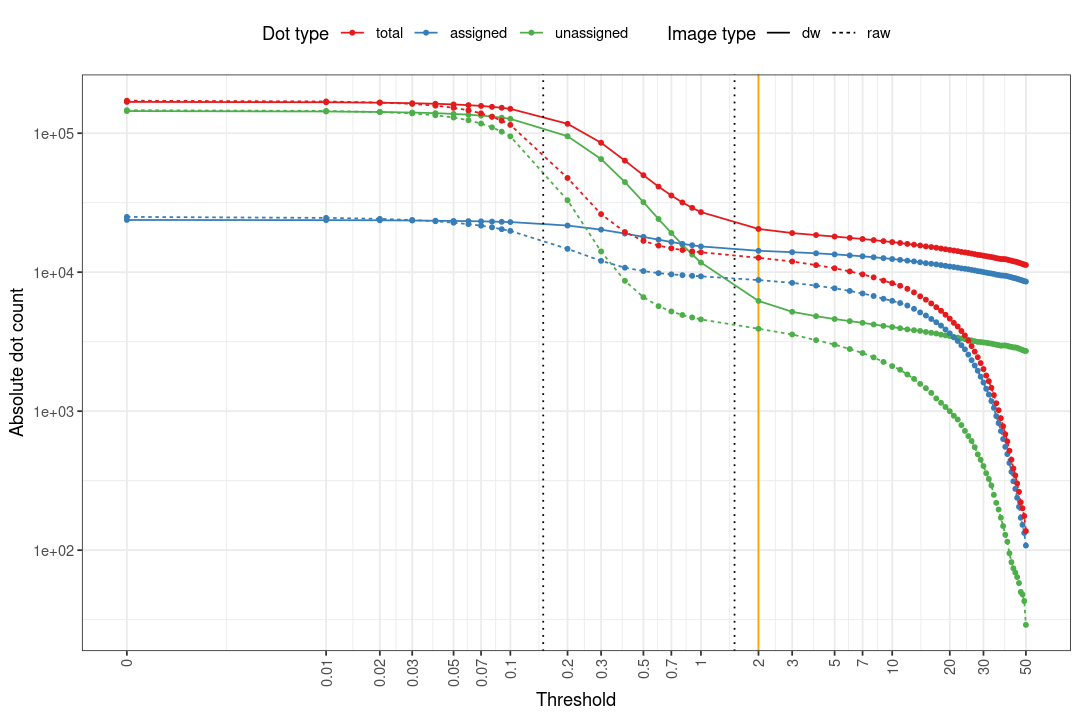

In [11]:
options(repr.plot.width=9, repr.plot.height=6)
p = ggplot(pdata, aes(x=thr+.001, y=N, linetype=image_type, color=variable)) +
    geom_vline(xintercept=c(2), color="orange", linetype="solid") +
    geom_line() + geom_point(size=1) +
    theme_bw() + scale_y_log10()  + scale_x_log10(breaks=x_breaks+.001, labels=x_breaks) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=.5), legend.position="top") +
    scale_fill_grey() + labs(x="Threshold", y="Absolute dot count", linetype="Image type", color="Dot type") +
    scale_color_brewer(palette="Set1") +
    geom_vline(xintercept=c(.15, 1.5), color="black", linetype="dotted")
print(p)

In [12]:
ggsave(plot=p, file="panels/fig_4a.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_4a.rds")

# Panel 4b
Transcript counts of DW vs Raw.

Warning message:
“Removed 10 rows containing missing values (geom_point).”


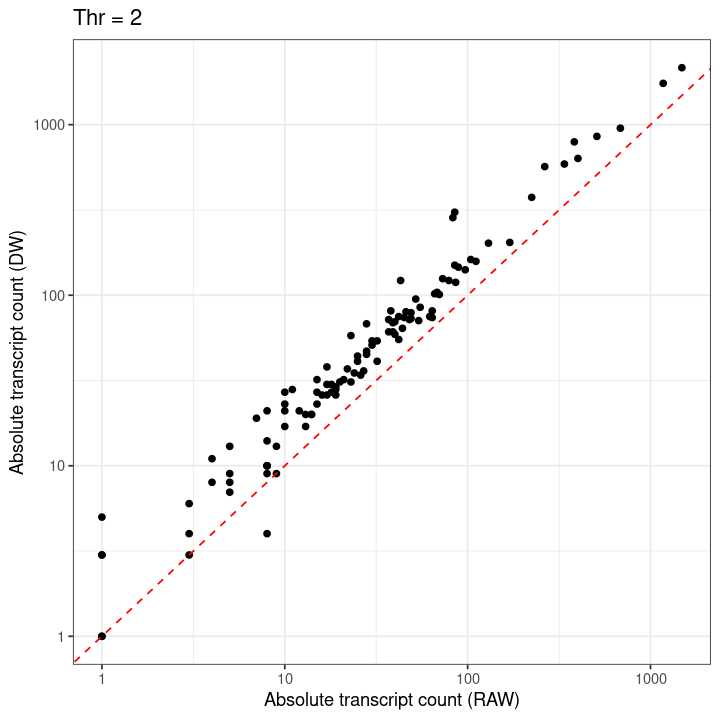

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
p = ggplot(gene_counts[thr==2], aes(raw, dw)) + geom_point() +
    scale_x_log10() + scale_y_log10() + theme_bw() +
    geom_abline(slope=1, linetype="dashed", color="red") +
    labs(x="Absolute transcript count (RAW)", y="Absolute transcript count (DW)", title="Thr = 2")
print(p)

In [14]:
ggsave(plot=p, file="panels/fig_4b.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_4b.rds")

Warning message:
“Removed 10 rows containing missing values (geom_point).”


# Panel 4c
Relative difference in transcripts count to identify most affected targets.

In [15]:
pdata = gene_counts[thr==2, .(reldelta=(dw-raw)/raw, raw)]
pdata[, selected := FALSE]
pdata[raw > 1 & reldelta >= 1.65, selected := TRUE]

Warning message:
“Removed 10 rows containing missing values (geom_point).”


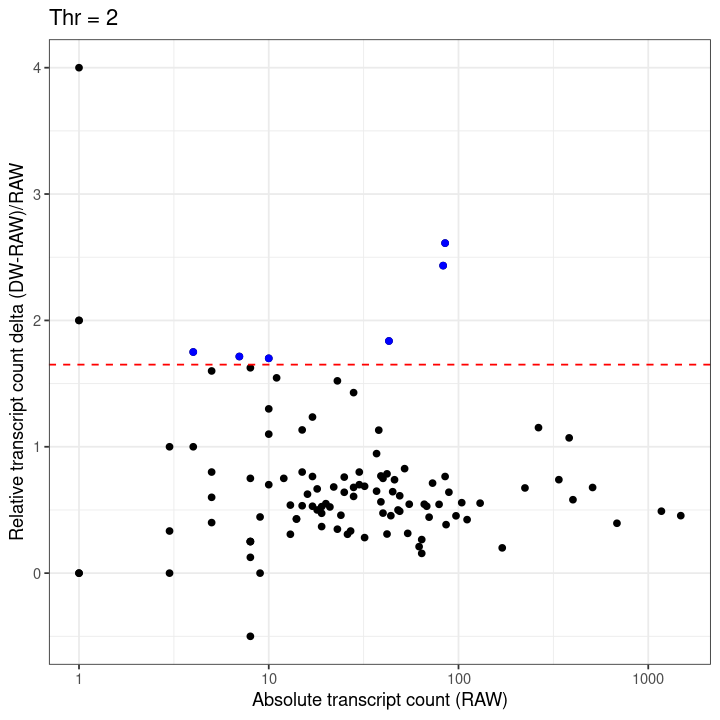

In [16]:
options(repr.plot.width=6, repr.plot.height=6)
p = ggplot(pdata, aes(raw, reldelta)) +
    geom_point() + geom_point(data=pdata[(selected)], color="blue") +
    theme_bw() + scale_x_log10() +
    geom_hline(yintercept=1.65, color="red", linetype="dashed") +
    labs(x="Absolute transcript count (RAW)", y="Relative transcript count delta (DW-RAW)/RAW", title="Thr = 2")
print(p)

In [17]:
ggsave(plot=p, file="panels/fig_4c.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_4c.rds")

Warning message:
“Removed 10 rows containing missing values (geom_point).”


# Panel 4d
Number of un/annotated cells

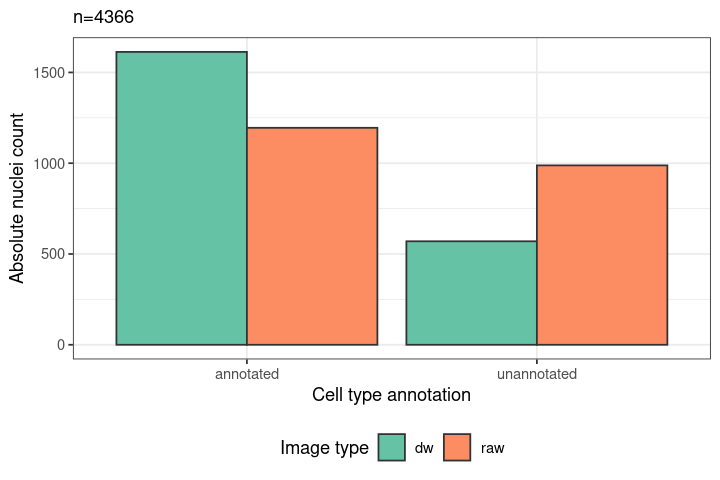

In [18]:
options(repr.plot.width=6, repr.plot.height=4)
p = ggplot(cell_data[, .N, by=c("annotated", "image_type")], aes(x=annotated, y=N, fill=image_type)) +
    geom_col(position="dodge", color="#323232") +
    theme_bw() + theme(legend.position="bottom") +
    scale_fill_brewer("Image type", palette="Set2") +
    labs(x="Cell type annotation", y="Absolute nuclei count", subtitle=sprintf("n=%d", nrow(cell_data)))
print(p)

In [19]:
ggsave(plot=p, file="panels/fig_4d.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_4d.rds")